In [1]:
import keras 
from keras.applications.densenet import DenseNet121
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D
from keras import optimizers, losses
from keras.callbacks import ModelCheckpoint
from keras.preprocessing import image

import pickle
import numpy as np
import matplotlib.pyplot as plt
import scipy

import warnings
warnings.filterwarnings("ignore")

In [2]:
train_dir = '../input/lumpyskindiseaseresearch/train'
valid_dir='../input/lumpyskindiseaseresearch/valid'

In [3]:
datagenerator = {
    "train": ImageDataGenerator(horizontal_flip=True,
                                vertical_flip=True,
                                rescale=1. / 255,
                                validation_split=0.1,
                                shear_range=0.1,
                                zoom_range=0.1,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                rotation_range=30,
                               ).flow_from_directory(directory=train_dir,
                                                     target_size=(256, 256),
                                                     subset='training',
                                                    ),

    "valid": ImageDataGenerator(rescale=1 / 255,
                                validation_split=0.1,
                               ).flow_from_directory(directory=valid_dir,
                                                     target_size=(256, 256),
                                                     subset='validation',
                                                    ), 
}

Found 843 images belonging to 2 classes.
Found 93 images belonging to 2 classes.


In [4]:
# Initializing InceptionV3 (pretrained) model with input image shape as (300, 300, 3)
base_model = DenseNet121(weights=None, include_top=False, input_shape=(256, 256, 3))

# Load Weights for the InceptionV3 Model
base_model.load_weights('../input/densenet-keras/DenseNet-BC-121-32-no-top.h5')

# Setting the Training of all layers of InceptionV3 model to false
base_model.trainable = False

In [5]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.15),
    Dense(1024, activation='relu'),
    Dense(2, activation='softmax') # 10 Output Neurons for 10 Classes
])

In [6]:
opt = optimizers.Adam(learning_rate=0.0001)

# Compiling and setting the parameters we want our model to use
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=['accuracy'])

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 8, 8, 1024)        7037504   
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 1024)              1049600   
                                                                 
 dense_1 (Dense)             (None, 2)                 2050      
                                                                 
Total params: 8089154 (30.86 MB)
Trainable params: 1051650 (4.01 MB)
Non-trainable params: 7037504 (26.85 MB)
____________

In [8]:
batch_size = 32
epochs = 10

# Seperating Training and Testing Data
train_generator = datagenerator["train"]
valid_generator = datagenerator["valid"]

In [9]:
# Calculating variables for the model
steps_per_epoch = train_generator.n // batch_size
validation_steps = valid_generator.n // batch_size

print("steps_per_epoch :", steps_per_epoch)
print("validation_steps :", validation_steps)

steps_per_epoch : 26
validation_steps : 2


In [10]:
import scipy


# File Path to store the trained models
filepath = "./model_{epoch:02d}-{val_accuracy:.2f}.h5"

# Using the ModelCheckpoint function to train and store all the best models
checkpoint1 = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint1]
# Training the Model
history = model.fit_generator(generator=train_generator, epochs=epochs, steps_per_epoch=steps_per_epoch,
                             validation_data=valid_generator, validation_steps=validation_steps,
                              callbacks=callbacks_list) 



Epoch 1/10
26/26 [==============================] - ETA: 0s - loss: 0.6474 - accuracy: 0.6338
Epoch 1: val_accuracy improved from -inf to 0.65625, saving model to .\model_01-0.66.h5
26/26 [==============================] - 89s 3s/step - loss: 0.6474 - accuracy: 0.6338 - val_loss: 0.5684 - val_accuracy: 0.6562
Epoch 2/10
26/26 [==============================] - ETA: 0s - loss: 0.5072 - accuracy: 0.7497
Epoch 2: val_accuracy improved from 0.65625 to 0.81250, saving model to .\model_02-0.81.h5
26/26 [==============================] - 78s 3s/step - loss: 0.5072 - accuracy: 0.7497 - val_loss: 0.3659 - val_accuracy: 0.8125
Epoch 3/10
26/26 [==============================] - ETA: 0s - loss: 0.4676 - accuracy: 0.7756
Epoch 3: val_accuracy improved from 0.81250 to 0.87500, saving model to .\model_03-0.88.h5
26/26 [==============================] - 82s 3s/step - loss: 0.4676 - accuracy: 0.7756 - val_loss: 0.3082 - val_accuracy: 0.8750
Epoch 4/10
26/26 [==============================] - ETA: 0s -

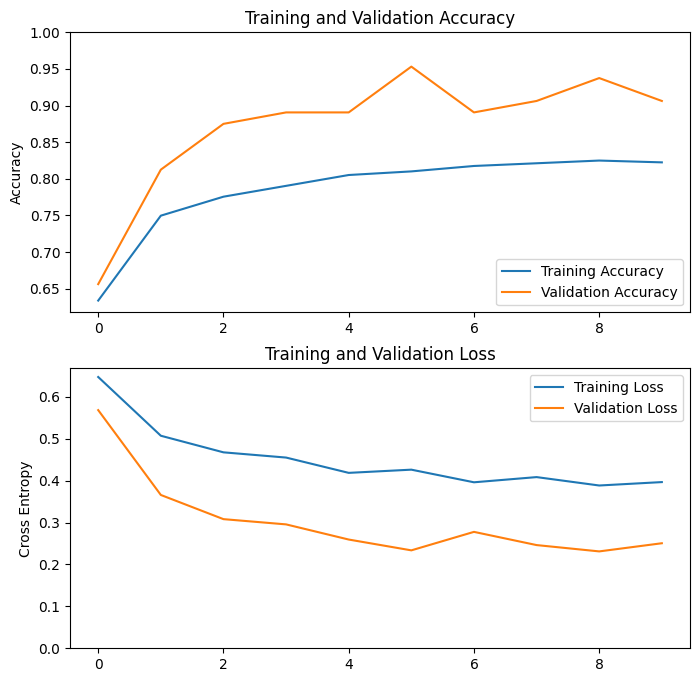

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# ________________ Graph 1 -------------------------

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

# ________________ Graph 2 -------------------------

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

In [12]:
test_loss, test_acc = model.evaluate(valid_generator)
print('test accuracy : ', test_acc)

3/3 [==============================] - 9s 3s/step - loss: 0.2461 - accuracy: 0.8925
test accuracy :  0.8924731016159058


In [13]:
from PIL import Image

# Check our folder and import the model with best validation accuracy
loaded_best_model = keras.models.load_model("models/model_07-0.97.h5")

# Custom function to load and predict label for the image
def predict(img_rel_path):
    # Import Image from the path with size of (300, 300)
    img = Image.open(img_rel_path)
    img = img.resize((256, 256))  # Resize image to (256, 256)

    # Convert Image to a numpy array
    img_array = np.array(img) / 255.0

    # Plotting the Loaded Image
    plt.title("Loaded Image")
    plt.axis('off')
    plt.imshow(img_array)
    plt.show()

    # Get the Predicted Label for the loaded Image
    p = loaded_best_model.predict(img_array[np.newaxis, ...])

    # Label array
    labels = {0: 'normal skin', 1: 'lumpsy Skin'}

    print("\n\nMaximum Probability: ", np.max(p[0], axis=-1))
    predicted_class = labels[np.argmax(p[0], axis=-1)]
    print("Classified:", predicted_class, "\n\n")

    classes=[]
    prob=[]
    print("\n-------------------Individual Probability--------------------------------\n")

    for i,j in enumerate(p[0]):
        print(labels[i].upper(),':',round(j*100,2),'%')
        classes.append(labels[i])
        prob.append(round(j*100,2))
        
    def plot_bar_x():
        # this is for plotting purpose
        index = np.arange(len(classes))
        plt.bar(index, prob)
        plt.xlabel('Labels', fontsize=8)
        plt.ylabel('Probability', fontsize=8)
        plt.xticks(index, classes, fontsize=8, rotation=20)
        plt.title('Probability for loaded image')
        plt.show()
    plot_bar_x()



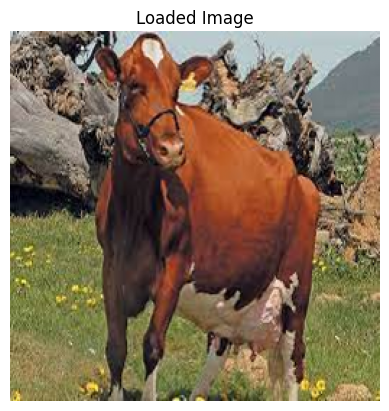

1/1 [==============================] - 0s 195ms/step


Maximum Probability:  0.66494393
Classified: normal skin 



-------------------Individual Probability--------------------------------

NORMAL SKIN : 66.49 %
LUMPSY SKIN : 33.51 %


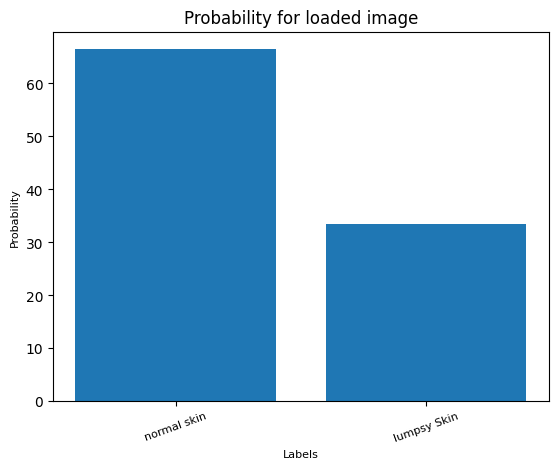

In [24]:
predict("../input/lumpyskindiseaseresearch/test/healthycows/imgs00.jpg")

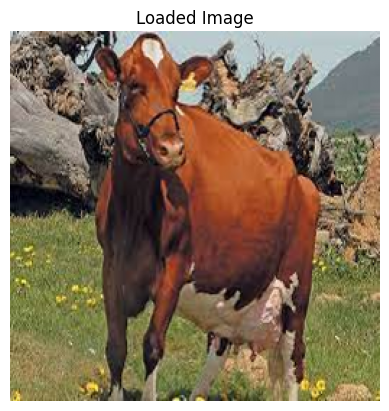

1/1 [==============================] - 0s 211ms/step


Maximum Probability:  0.66494393
Classified: normal skin 



-------------------Individual Probability--------------------------------

NORMAL SKIN : 66.49 %
LUMPSY SKIN : 33.51 %


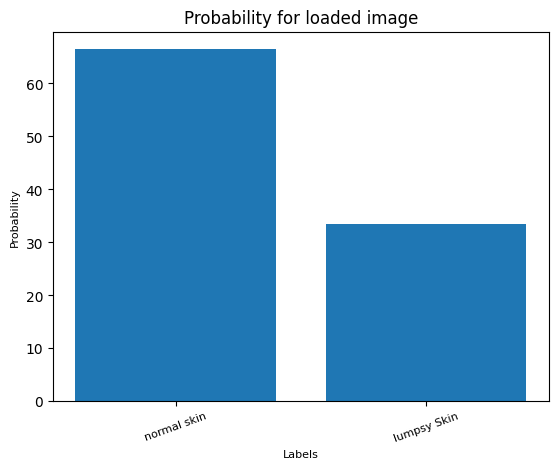

In [25]:
predict("../input/lumpyskindiseaseresearch/test/healthycows/imgs005.jpg")

In [26]:
import cv2
def predict_video(image_array):
    try:
        # Assuming loaded_best_model is a pre-trained model

        # Check the shape and range of the image array
        print("Image array shape:", image_array.shape)
        print("Image array min/max:", np.min(image_array), np.max(image_array))

        # Resize the image to (256, 256)
        img = Image.fromarray((image_array * 255).astype(np.uint8))
        img = img.resize((256, 256), resample=Image.BILINEAR)  # Use a high-quality resampling method

        # Convert Image to a numpy array and normalize
        img_array = np.array(img).astype(np.uint8)
        print("Image array content:", img_array)
        # Save the resized image
        img.save("resized_image.jpg")





        # Plotting the Loaded Image
        cv2.imshow("Loaded Image", img_array)
        cv2.waitKey(0)
        cv2.destroyAllWindows()


        # Get the Predicted Label for the loaded Image
        p = loaded_best_model.predict(img_array[np.newaxis, ...])

        # Label array
        labels = {0: 'normal skin', 1: 'lumpy Skin'}

        print("\n\nMaximum Probability: ", np.max(p[0], axis=-1))
        predicted_class = labels[np.argmax(p[0], axis=-1)]
        print("Classified:", predicted_class, "\n\n")

        classes = []
        prob = []
        print("\n-------------------Individual Probability--------------------------------\n")

        for i, j in enumerate(p[0]):
            print(labels[i].upper(), ':', round(j * 100, 2), '%')
            classes.append(labels[i])
            prob.append(round(j * 100, 2))

        # Plot the probability distribution
        plot_bar_x(classes, prob)
    
    except Exception as e:
        print("An error occurred:", e)


def plot_bar_x(classes, prob):
    # Plotting the probability distribution
    index = np.arange(len(classes))
    plt.bar(index, prob)
    plt.xlabel('Labels', fontsize=8)
    plt.ylabel('Probability', fontsize=8)
    plt.xticks(index, classes, fontsize=8, rotation=20)
    plt.title('Probability for loaded image')
    plt.show()


Detected Labels: ['Cow']
Cow or Cattle Detected!
Image array shape: (538, 738, 3)
Image array min/max: 0 255
Image array content: [[[254   0   0]
  [254   0   0]
  [254   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[254   0   0]
  [254   0   0]
  [254   0   3]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[253   0  49]
  [253   0  49]
  [253   0  62]
  ...
  [  0   0  49]
  [  0   0  49]
  [  0   0  49]]

 ...

 [[100  90  86]
  [132 123 119]
  [150 140 136]
  ...
  [169 159 158]
  [164 155 154]
  [163 155 153]]

 [[ 88  80  76]
  [ 92  83  79]
  [125 117 113]
  ...
  [169 159 158]
  [165 156 155]
  [173 164 162]]

 [[ 97  89  85]
  [ 86  78  74]
  [105  97  93]
  ...
  [170 160 159]
  [167 158 157]
  [179 170 169]]]
1/1 [==============================] - 0s 186ms/step


Maximum Probability:  0.93735015
Classified: lumpy Skin 



-------------------Individual Probability--------------------------------

NORMAL SKIN : 6.26 %
LUMPY SKIN : 93.74 %


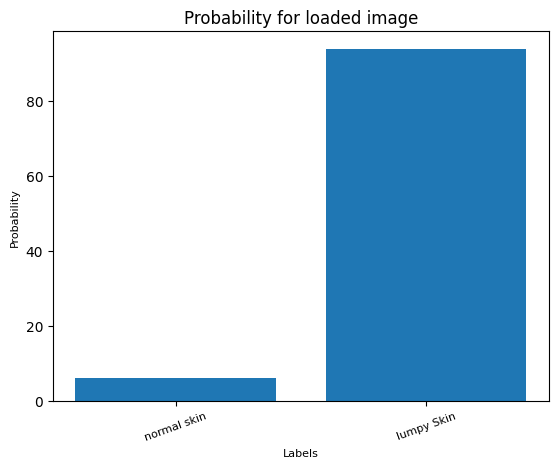

Assigned Behaviors: ['standing (None)']
Detected Labels: ['Cow']
Cow or Cattle Detected!
Image array shape: (543, 924, 3)
Image array min/max: 0 255
Image array content: [[[181 172 157]
  [194 185 170]
  [208 199 186]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[182 173 158]
  [194 185 170]
  [200 190 176]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[183 174 159]
  [193 184 169]
  [181 170 155]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 ...

 [[ 50 171 227]
  [ 50 118 183]
  [ 49  60 169]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[107 152 254]
  [107 137 254]
  [106  79 254]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[255 255 255]
  [255 255 255]
  [252 188 255]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
1/1 [==============================] - 0s 185ms/step


Maximum Probability:  0.93440807
Classified: lumpy Skin 



-------------------Individual Probability--------------------------------

NORMAL SKI

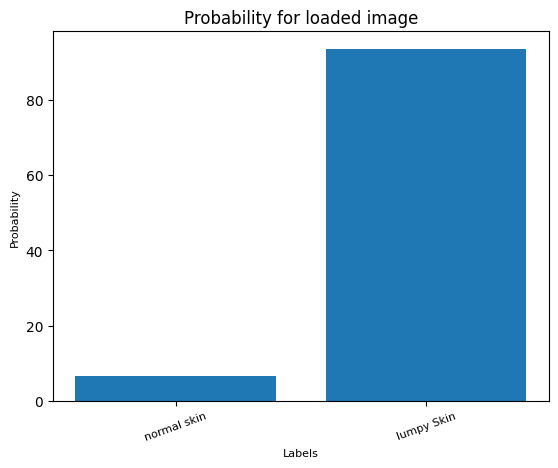

Assigned Behaviors: ['standing (None)']
Detected Labels: ['Cow']
Cow or Cattle Detected!
Image array shape: (538, 924, 3)
Image array min/max: 0 255
Image array content: [[[  0   0   0]
  [ 37  35 150]
  [201 193 201]
  ...
  [ 70  47  23]
  [ 79  57  33]
  [ 80  58  35]]

 [[115   0   0]
  [ 92  35 150]
  [202 194 201]
  ...
  [ 73  51  23]
  [ 79  57  30]
  [ 79  57  31]]

 [[202   0   0]
  [134  36 149]
  [201 195 201]
  ...
  [ 75  52  22]
  [ 78  55  26]
  [ 78  55  26]]

 ...

 [[  0   0   0]
  [ 29  28 144]
  [148 141 159]
  ...
  [105 102  98]
  [182 179 175]
  [181 177 175]]

 [[  0   0   0]
  [ 29  28 144]
  [152 147 165]
  ...
  [105 101  99]
  [188 184 182]
  [188 184 182]]

 [[  0   0   0]
  [ 81  81 150]
  [199 197 205]
  ...
  [126 123 121]
  [222 219 217]
  [222 218 216]]]
1/1 [==============================] - 0s 184ms/step


Maximum Probability:  0.50125635
Classified: normal skin 



-------------------Individual Probability--------------------------------

NORMAL SK

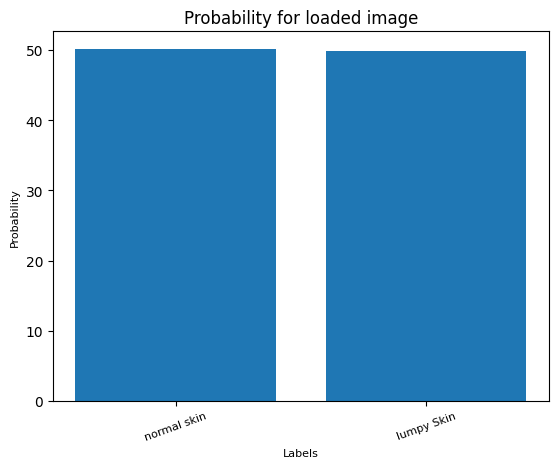

Assigned Behaviors: ['standing (None)']
Detected Labels: ['Cow']
Cow or Cattle Detected!
Image array shape: (544, 966, 3)
Image array min/max: 0 255
Image array content: [[[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [ 92  92 254]
  [ 92  92 254]
  [ 92  92 254]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [189 178 170]
  [196 182 167]
  [196 180 163]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [183 174 165]
  [189 178 167]
  [190 178 166]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [175 168 162]
  [176 169 161]
  [176 168 160]]]
1/1 [==============================] - 0s 188ms/step


Maximum Probability:  0.9652003
Classified: lumpy Skin 



-------------------Individual Probability--------------------------------

NORMAL SKIN

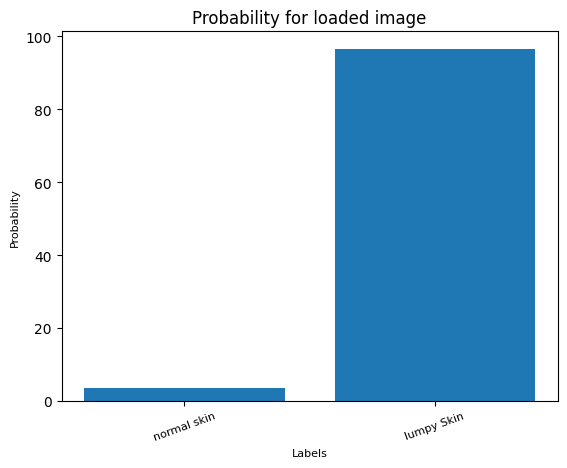

Assigned Behaviors: ['standing (None)']
Detected Labels: ['Teddy bear', 'Dog']
Assigned Behaviors: ['unknown', 'unknown']
Detected Labels: []
Assigned Behaviors: []
Detected Labels: ['Dog']
Assigned Behaviors: ['unknown']
Detected Labels: []
Assigned Behaviors: []
Detected Labels: ['TV']
Assigned Behaviors: ['unknown']
Detected Labels: []
Assigned Behaviors: []
Detected Labels: ['Dog']
Assigned Behaviors: ['unknown']
Detected Labels: ['Dog']
Assigned Behaviors: ['unknown']
Detected Labels: ['TV']
Assigned Behaviors: ['unknown']
Detected Labels: []
Assigned Behaviors: []
Detected Labels: ['Cow']
Cow or Cattle Detected!
Image array shape: (541, 569, 3)
Image array min/max: 0 255
Image array content: [[[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [ 44   0 255]
  [ 44   0 255]
  [ 44   0 255]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [230   0 254]
  [230   0 254]
  [230   0 254]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [ 95   0 253]
  [ 95   0 253]

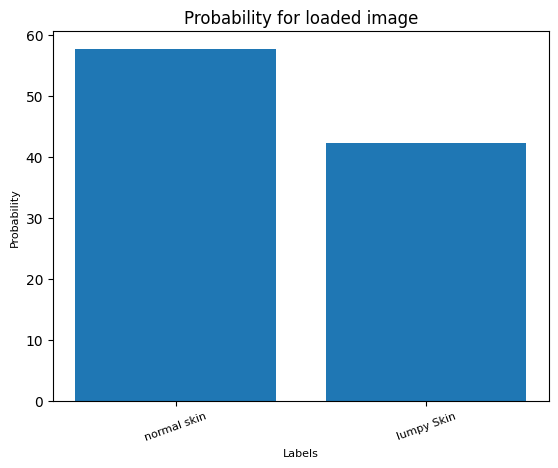

Assigned Behaviors: ['standing (None)']
Detected Labels: ['Cow']
Cow or Cattle Detected!
Image array shape: (564, 940, 3)
Image array min/max: 0 255
Image array content: [[[157   0   0]
  [157   0   0]
  [157   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[254   0   0]
  [254   0   0]
  [254   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[254   0   0]
  [254   0   0]
  [254   0   0]
  ...
  [  6   0   1]
  [  4   0   5]
  [ 11   0   0]]

 ...

 [[113 103 103]
  [109 105  99]
  [111 104  99]
  ...
  [193 192 184]
  [190 185 181]
  [175 175 164]]

 [[141 141 142]
  [128 153 168]
  [149 106 157]
  ...
  [ 52 110 243]
  [ 52  57 244]
  [ 52 108 242]]

 [[  0 255 158]
  [  0 228 158]
  [  0 184  90]
  ...
  [ 97   0 249]
  [ 97   0 249]
  [ 97   0 249]]]
1/1 [==============================] - 0s 188ms/step


Maximum Probability:  0.97902197
Classified: lumpy Skin 



-------------------Individual Probability--------------------------------

NORMAL SKI

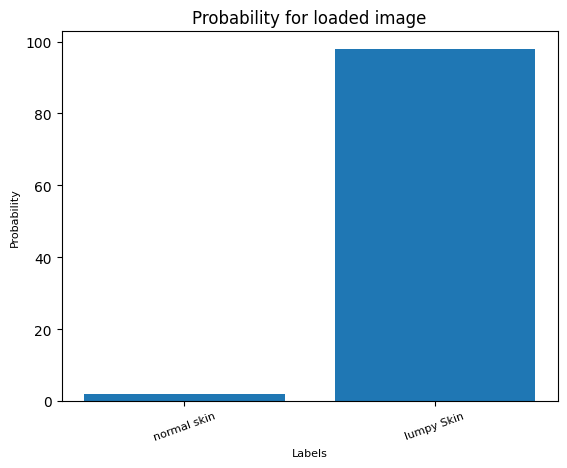

Assigned Behaviors: ['standing (None)']
Detected Labels: ['Cat', 'Dog']
Assigned Behaviors: ['unknown', 'unknown']
Detected Labels: ['TV']
Assigned Behaviors: ['unknown']
Detected Labels: ['Cow', 'Cow']
Cow or Cattle Detected!
Image array shape: (521, 524, 3)
Image array min/max: 0 255
Image array content: [[[200 193 182]
  [197 191 180]
  [196 191 180]
  ...
  [215 215  26]
  [226 226 188]
  [ 40  40  40]]

 [[206 200 188]
  [203 198 186]
  [201 197 185]
  ...
  [215 215  26]
  [226 226 188]
  [ 40  40  40]]

 [[211 206 193]
  [208 203 190]
  [206 203 190]
  ...
  [183 183  26]
  [192 192 188]
  [ 34  34  40]]

 ...

 [[ 45  30  20]
  [144 128 117]
  [193 177 168]
  ...
  [188   0   0]
  [ 37   0   0]
  [  0   0   0]]

 [[ 34  20   9]
  [117 103  91]
  [191 176 166]
  ...
  [188   0   0]
  [ 37   0   0]
  [  0   0   0]]

 [[ 27  13   4]
  [ 85  70  60]
  [185 170 161]
  ...
  [188   0   0]
  [ 37   0   0]
  [  0   0   0]]]
1/1 [==============================] - 0s 193ms/step


Maximum

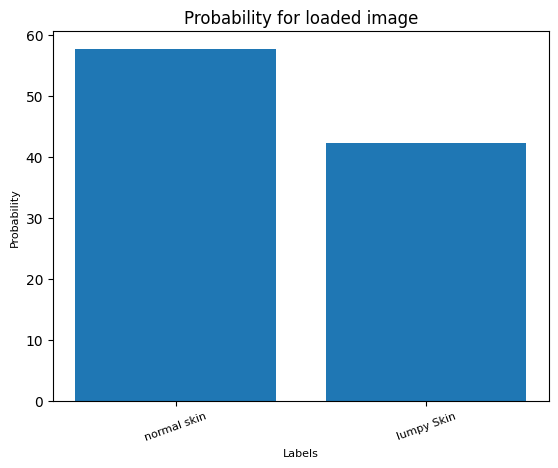

Cow or Cattle Detected!
Image array shape: (446, 361, 3)
Image array min/max: 8 255
Image array content: [[[194 179 163]
  [192 177 161]
  [184 168 153]
  ...
  [140 142 130]
  [181 184 169]
  [198 201 184]]

 [[193 178 162]
  [193 178 162]
  [184 168 153]
  ...
  [164 166 153]
  [197 199 184]
  [203 206 189]]

 [[193 180 162]
  [192 178 160]
  [183 169 151]
  ...
  [187 189 176]
  [202 205 189]
  [205 206 189]]

 ...

 [[160 153 142]
  [162 155 144]
  [152 145 134]
  ...
  [223 211 186]
  [227 214 189]
  [228 216 190]]

 [[154 147 136]
  [149 142 131]
  [148 143 132]
  ...
  [226 212 189]
  [229 216 193]
  [231 218 195]]

 [[158 153 142]
  [147 142 131]
  [150 145 134]
  ...
  [229 215 192]
  [232 219 196]
  [234 221 198]]]
1/1 [==============================] - 0s 187ms/step


Maximum Probability:  0.8840771
Classified: lumpy Skin 



-------------------Individual Probability--------------------------------

NORMAL SKIN : 11.59 %
LUMPY SKIN : 88.41 %


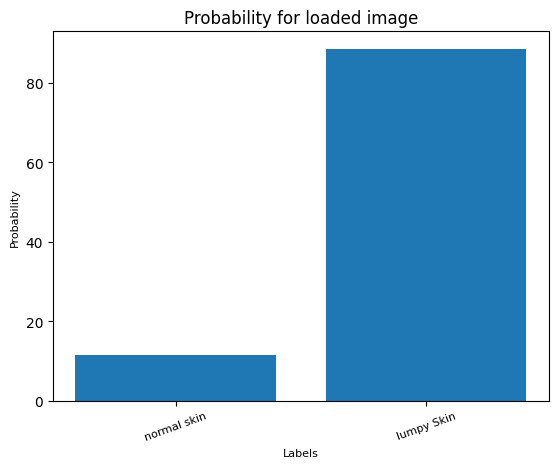

Assigned Behaviors: ['standing (None)', 'standing (None)']
Detected Labels: ['Cow']
Cow or Cattle Detected!
Image array shape: (552, 822, 3)
Image array min/max: 0 255
Image array content: [[[ 46   0  26]
  [ 46   0   0]
  [ 46   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[231   0 132]
  [231   0   0]
  [231   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[254   0 145]
  [254   0   0]
  [254   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 ...

 [[167 162 151]
  [139 132 121]
  [142 134 124]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[172 167 156]
  [144 139 128]
  [148 143 132]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[181 177 168]
  [158 154 144]
  [149 145 135]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]
1/1 [==============================] - 0s 184ms/step


Maximum Probability:  0.9140237
Classified: lumpy Skin 



-------------------Individual Probability--------------------------

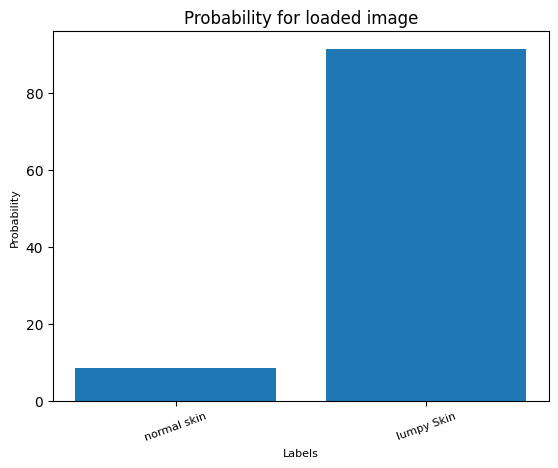

Assigned Behaviors: ['standing (None)']
Detected Labels: ['Cat']
Assigned Behaviors: ['unknown']
Detected Labels: ['Dog']
Assigned Behaviors: ['unknown']
Detected Labels: ['Dog']
Assigned Behaviors: ['unknown']
Detected Labels: ['Dog']
Assigned Behaviors: ['unknown']
Detected Labels: ['Dog', 'TV']
Assigned Behaviors: ['unknown', 'unknown']
Detected Labels: ['Dog']
Assigned Behaviors: ['unknown']
Detected Labels: ['TV']
Assigned Behaviors: ['unknown']
End of video.


In [28]:
import cv2
import os

class CowDetection:
    def __init__(self, model_pb, config_pbtxt, coco_label_txt):
        self.net = cv2.dnn.readNetFromTensorflow(model_pb, config_pbtxt)
        self.labels = self._read_label(coco_label_txt)
        
    def predict(self, image, min_confidence=0.3, max_iou=0.3):
        blob = cv2.dnn.blobFromImage(image, size=(300, 300), swapRB=True, crop=False)
        self.net.setInput(blob)
        detections = self.net.forward()
        result = []
        for detection in detections[0, 0]:
            confidence = detection[2]
            class_id = int(detection[1])
            if confidence > min_confidence:
                label = self.labels[class_id]
                x1, y1, x2, y2 = int(detection[3] * image.shape[1]), int(detection[4] * image.shape[0]), \
                                 int(detection[5] * image.shape[1]), int(detection[6] * image.shape[0])
                bbox = (x1, y1, x2, y2)
                result.append((bbox, label, confidence))
        return result
    
    def _read_label(self, label_txt_file):
        with open(label_txt_file, "r") as f:
            labels = [line.strip("\n") for line in f]
        return labels

class CowBehaviorMonitoring:
    def __init__(self, model_pb, config_pbtxt, coco_label_txt, behavior_labels):
        self.cow_detector = CowDetection(model_pb, config_pbtxt, coco_label_txt)
        self.behavior_labels = behavior_labels
        self.frame_count = 0
    
    def detect_cows_and_behaviors(self, frame):
        self.frame_count += 1
        if self.frame_count % 30 != 0:  # Process every 30th frame
            return None
        
        detections = self.cow_detector.predict(frame, min_confidence=MIN_CONF, max_iou=MAX_IOU)
        bbox = [bbox for bbox, _, _ in detections]
        labels = [label for _, label, _ in detections]
        scores = [score for _, _, score in detections]
        print("Detected Labels:", labels)
        behaviors = []
        for bbox, label, score in detections:
            behavior = self._classify_behavior(label)
            if behavior != "unknown":
                if isinstance(bbox, int):  # Check if bbox is an integer
                    bbox = (bbox,)  # Convert single integer to tuple
                x1, y1, x2, y2 = bbox
                cow_image = frame[y1:y2, x1:x2]
                skin_classification = predict_video(cow_image)
                behavior += f" ({skin_classification})"
            behaviors.append(behavior)
        print("Assigned Behaviors:", behaviors)
        return bbox, behaviors, scores
    
    def _classify_behavior(self, label):
        if label.lower() in ["cow", "cattle"]:
            print("Cow or Cattle Detected!")
            return "standing"
        elif label.lower() == "eating":
            return "eating"
        elif label.lower() == "sitting":
            return "sitting"
        elif label.lower() in self.behavior_labels:
            return label.lower()
        else:
            return "unknown"

    def draw_behavior_info(self, frame, bbox, behaviors, scores):
        print("Bounding Boxes:", bbox)
        print("Behaviors:", behaviors)
        print("Scores:", scores)

        frame_copy = frame.copy()
        if isinstance(bbox, int):
            bbox = [(bbox,)]  # Convert single integer to a tuple inside a list
        for (x1, y1, x2, y2), behavior, conf in zip(bbox, behaviors, scores):
            if isinstance(x1, int) and isinstance(y1, int) and isinstance(x2, int) and isinstance(y2, int):
                x1, y1, x2, y2 = 0, 0, 0, 0  # Set default values for coordinates
            else:
                x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
            cv2.rectangle(frame_copy, (x1, y1), (x2, y2), (0, 255, 255), 2)
            cv2.putText(frame_copy, f"{behavior.title()}: {conf:.2f}", (x1, y1 - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 2)
        return frame_copy


# Configuration variables
VIDEO_FILE = "Cow-Detection-using-OpenCV/data/lumpy.mp4"
MODEL_PATH = "Cow-Detection-using-OpenCV/model/mobilenet_v2_ssd_coco_frozen_graph.pb"
CONFIG_PATH = "Cow-Detection-using-OpenCV/model/mobilenet_v2_ssd_coco_config.pbtxt"
LABEL_PATH = "Cow-Detection-using-OpenCV/model/coco_class_labels.txt"
MIN_CONF = 0.1
MAX_IOU = 0.3
BEHAVIOR_LABELS = ["standing", "eating", "sitting"]

if __name__ == "__main__":
    # Open video file
    cap = cv2.VideoCapture(VIDEO_FILE)
    if not cap.isOpened():
        print("Error: Could not open video file.")
        exit()

    # Create CowBehaviorMonitoring instance
    behavior_monitor = CowBehaviorMonitoring(MODEL_PATH, CONFIG_PATH, LABEL_PATH, BEHAVIOR_LABELS)

    while True:
        ret, frame = cap.read()
        if not ret:
            print("End of video.")
            break
        
        behavior_monitor.detect_cows_and_behaviors(frame)
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            print("Exiting...")
            break

    cap.release()
    cv2.destroyAllWindows()
